## Import Libraries

This example was adapted from 3 different binary classification tutorials:

https://www.learnpytorch.io/02_pytorch_classification/
https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe
https://www.shuffleai.blog/blog/pytorch_coding_binary_cls.html

And you can see the tutorial for the Quantum layer in Pytorch in this Pennylane tutorial:
https://pennylane.ai/qml/demos/tutorial_qnn_module_torch/

In [1]:
#%pip install scikit-learn

In [2]:
import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

## Create Data

In [3]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, Y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

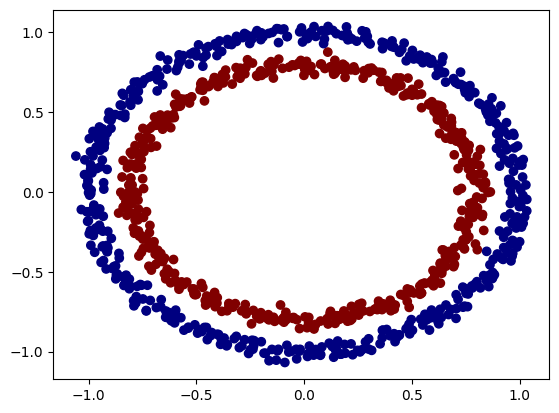

In [4]:
#X, Y = make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1)
plt.scatter(X[:, 0], X[:, 1], c=Y,cmap='jet')

In [5]:
x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.float32)).view(-1,1)

## Classical Model

In [6]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 8)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(8, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

net = Net()

## Quantum Model

In [7]:
n_qubits = 4

In [8]:
dev = qml.device("lightning.qubit", wires= n_qubits)

In [9]:
# Number of variational layers
q_depth = 2

In [10]:
@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):

    # Init distribution
    for a in range(n_qubits):
        qml.Hadamard(wires=a)

    # Input distribution
    for b in range(n_qubits):
        qml.RY(inputs[(2 * b) ], wires=b)
        qml.RZ(inputs[(2 * b) + 1], wires=b)

    # Variational circuit
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RY(weights[2*(i*n_qubits + j) ], wires=j)
            qml.RZ(weights[2*(i*n_qubits + j) + 1], wires=j)
        for l in range(n_qubits):
            if (l == (n_qubits - 1)):
                qml.CNOT(wires=[l,0])
            else:
                qml.CNOT(wires=[l,l+1])

    for k in range(n_qubits):
        qml.RY(weights[(2*q_depth * n_qubits) + k ], wires=k)
        qml.RZ(weights[(2*q_depth * n_qubits) + k + 1], wires=k)

    # Measurement
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [11]:
n_args = 2*(q_depth +1) * n_qubits
weight_shapes = {"weights": n_args}

In [12]:
# Visualize the circuit
print(qml.draw(qnode)(inputs = np.random.rand(n_qubits * 2), weights = np.random.rand(n_args)))

0: ──H──RY(0.35)──RZ(0.35)──RY(0.11)──RZ(0.05)─╭●───────╭X──RY(0.29)──RZ(0.70)─╭●───────╭X──RY(0.12)
1: ──H──RY(0.14)──RZ(0.33)──RY(0.10)──RZ(0.97)─╰X─╭●────│───RY(0.54)──RZ(0.29)─╰X─╭●────│───RY(0.00)
2: ──H──RY(0.55)──RZ(0.62)──RY(0.07)──RZ(0.03)────╰X─╭●─│───RY(0.72)──RZ(0.49)────╰X─╭●─│───RY(0.11)
3: ──H──RY(0.86)──RZ(0.52)──RY(0.41)──RZ(0.92)───────╰X─╰●──RY(0.48)──RZ(0.88)───────╰X─╰●──RY(0.88)

───RZ(0.00)─┤  <Z>
───RZ(0.11)─┤  <Z>
───RZ(0.88)─┤  <Z>
───RZ(0.72)─┤  <Z>


In [13]:
class QNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(4, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.qlayer_1(dout[0])
        h2 = self.relu2(a2.unsqueeze(0))
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

qnet = QNet()

## Training functions

In [14]:
def train_epoch(model, opt, criterion, X, Y):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0)):
        x_batch = X[beg_i:beg_i + 1, :]
        y_batch = Y[beg_i:beg_i + 1, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.data.numpy())
    return losses

## Train Classical Model

In [15]:
# Define Optimizer and loss function
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [16]:
start = time.time()
e_losses = []
num_epochs = 5
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion, x, y)
#plt.plot(e_losses)
end = time.time()

In [17]:
print("Execution time", end - start)

Execution time 6.1850690841674805


In [18]:
test_pred = torch.round(net(x))

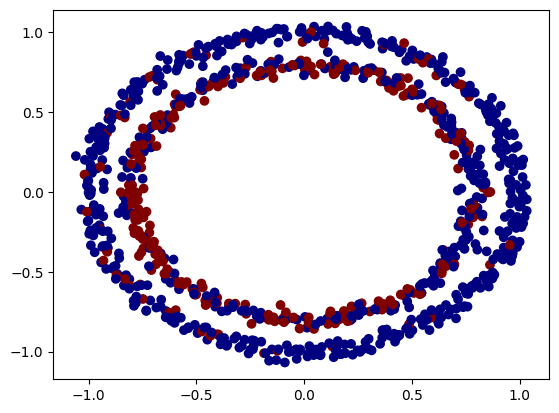

In [19]:
plt.scatter(X[:, 0], X[:, 1], c=test_pred[:, 0].detach().numpy() ,cmap='jet')

In [20]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [21]:
accuracy_fn(y, test_pred)

69.0

## Train Quantum model

In [22]:
# Define Optimizer and loss function
q_opt = optim.Adam(qnet.parameters(), lr=0.02, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [23]:
start = time.time()
e_losses_q = []
num_epochs = 5
for e in range(num_epochs):
    start_epoch = time.time()
    e_losses_q += train_epoch(qnet, q_opt, criterion, x, y)
    end_epoch = time.time()
    print("Execution time for epoch ", e, " : ", end_epoch - start_epoch)
end = time.time()

Execution time for epoch  0  :  164.49724340438843
Execution time for epoch  1  :  148.37842726707458
Execution time for epoch  2  :  160.7576744556427
Execution time for epoch  3  :  175.8254177570343
Execution time for epoch  4  :  178.5218608379364


In [24]:
print("Execution time", end - start)

Execution time 827.9816136360168


In [25]:
test_pred_q = torch.empty((1000,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q[i] = torch.round(qnet(x_temp))

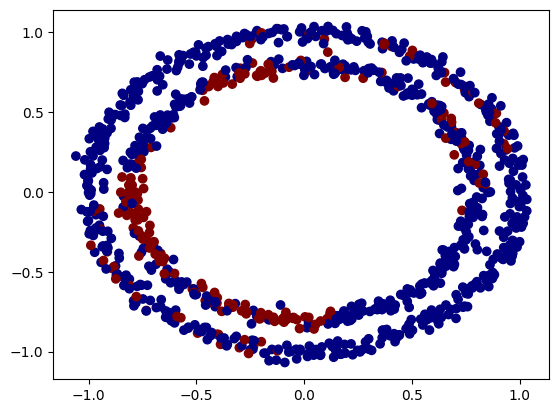

In [26]:
plt.scatter(X[:, 0], X[:, 1], c=test_pred_q[:, 0].detach().numpy() ,cmap='jet')

In [27]:
accuracy_fn(y, test_pred_q)

61.199999999999996